In [1]:
import pandas as pd
from copy import deepcopy as dc
import itertools
from itertools import combinations
from itertools import permutations
import numpy as np
from scipy.optimize import linprog
import math
import pickle
#from graphviz import Digraph
import time
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import methode_derivee as md

def get_signature(x):
    return_string = ''
    for ele in list_entite:
        return_string = return_string + str(int(x[ele]))
    return return_string


def simulation(ini_d_s, ini_c_s, nb_ite):
    """
    initial_discrete_state = '100'
    initial_domain = [0.1,0.2,0.3]
    """
    nb_dim = len(ini_c_s)
    return_series = np.zeros((1, nb_dim))
    times = np.zeros((1, 1))
    count = 0
    for dim_i in range(nb_dim):
        return_series[0][dim_i] = int(ini_d_s[dim_i]) + ini_c_s[dim_i]
    times[0][0] = 0
    d_s = ini_d_s
    c_s = ini_c_s.copy()
    for num_ite in range(nb_ite):
        # instant transition
        instant_transition = True
        current_d_s = dc(d_s)
        c_count = 0
        while instant_transition:
            instant_transition = False
            for dim_i in range(nb_dim):
                if c_s[dim_i] == 1 and classify_boundary(d_s, dim_i, 1) == 'output':
                    instant_transition = True
                    c_s[dim_i] = 0
                    d_s = d_s[0:dim_i] + str(int(d_s[dim_i]) + 1) + d_s[dim_i + 1:]
                    break
                elif c_s[dim_i] == 0 and classify_boundary(d_s, dim_i, -1) == 'output':
                    instant_transition = True
                    c_s[dim_i] = 1
                    d_s = d_s[0:dim_i] + str(int(d_s[dim_i]) - 1) + d_s[dim_i + 1:]
                    break
            c_count = c_count + 1
            #             print(d_s)
            if c_count > 1 and current_d_s == d_s:
                return (return_series, times)
        delta_t = math.inf
        first_touch_dim = nb_dim
        first_touch_sign = 0
        one_return_series = np.zeros((1, nb_dim))
        one_times = np.zeros((1, 1))
        set_att = []
        for dim_i in range(nb_dim):
            if c_s[dim_i] == 1 and classify_boundary(d_s, dim_i, 1) == 'attractif':
                set_att = set_att + [dim_i]
            elif c_s[dim_i] == 0 and classify_boundary(d_s, dim_i, -1) == 'attractif':
                set_att = set_att + [dim_i]
        if len(set_att) == nb_dim:
            return (return_series, times)
        for dim_i in range(nb_dim):
            if dim_i not in set_att:
                speed = get_celerity(d_s, dim_i)
                if speed > 0:
                    delta = (1 - c_s[dim_i]) / speed
                    sign = 1
                elif speed < 0:
                    delta = (0 - c_s[dim_i]) / speed
                    sign = 0
                elif speed == 0:
                    delta = math.inf
                if delta < delta_t:
                    delta_t = delta
                    first_touch_dim = dim_i
                    first_touch_sign = sign
        # check if two boundary are reached at the same time
        for dim_i in range(nb_dim):
            if dim_i not in set_att:
                speed = get_celerity(d_s, dim_i)
                if speed > 0:
                    delta = (1 - c_s[dim_i]) / speed
                    sign = 1
                elif speed < 0:
                    delta = (0 - c_s[dim_i]) / speed
                    sign = 0
                elif speed == 0:
                    delta = math.inf
                if delta == delta_t and dim_i != first_touch_dim:
                    print('reach two new boundaries at the same time!')

        c_s[first_touch_dim] = first_touch_sign
        count = count + delta_t
        for dim_i in range(nb_dim):
            if dim_i not in set_att and dim_i != first_touch_dim:
                speed = get_celerity(d_s, dim_i)
                c_s[dim_i] = c_s[dim_i] + delta_t * speed
            one_return_series[0][dim_i] = int(d_s[dim_i]) + c_s[dim_i]
        #         print('discrete state:',d_s)
        #         print('continuous state:',c_s)
        #         print('***********************')
        one_times[0][0] = count
        return_series = np.vstack([return_series, one_return_series])
        times = np.vstack([times, one_times])
    return (return_series, times)


def classify_boundary(state, dim, domain):
    """
    state: '010'
    dim: 2
    domain: 1/0/-1
    """
    current_row = celerities.query('signature == @state')
    speed = current_row['c_' + list_entite[dim]].values[0]
    if domain == 0:
        return 'interior'
    elif domain == 1:
        if speed > 0:
            if int(state[dim]) == max_level[list_entite[dim]]:
                return 'attractif'
            else:
                upper_discrete_state = state
                upper_discrete_state = list(upper_discrete_state)
                upper_discrete_state[dim] = str(int(upper_discrete_state[dim]) + 1)
                upper_discrete_state = "".join(upper_discrete_state)
                upper_speed = celerities.query('signature == @upper_discrete_state')['c_' + list_entite[dim]].values[0]
                if upper_speed <= 0:
                    return 'attractif'
                elif upper_speed > 0:
                    return 'output'
        elif speed == 0:
            return 'neutral'
        elif speed < 0:
            return 'input'
    elif domain == -1:
        if speed < 0:
            if int(state[dim]) == 0:
                return 'attractif'
            else:
                lower_discrete_state = state
                lower_discrete_state = list(lower_discrete_state)
                lower_discrete_state[dim] = str(int(lower_discrete_state[dim]) - 1)
                lower_discrete_state = "".join(lower_discrete_state)
                lower_speed = celerities.query('signature == @lower_discrete_state')['c_' + list_entite[dim]].values[0]
                if lower_speed >= 0:
                    return 'attractif'
                elif lower_speed < 0:
                    return 'output'
        elif speed == 0:
            return 'neutral'
        elif speed > 0:
            return 'input'


def get_celerity(state, dim):
    current_row = celerities.query('signature == @state')
    speed = current_row['c_' + list_entite[dim]].values[0]
    return speed


def get_transition_matrix(state, first_domain, second_domain):
    """
    state: '0101'
    first_domain(second_domain): [0,-1,1,0]
    """
    # get first reach dimension
    first_reach_dim = len(second_domain) + 1
    for num_dim in range(len(second_domain)):
        if second_domain[num_dim] in [-1, 1] and first_domain[num_dim] != second_domain[num_dim]:
            first_reach_dim = num_dim
            break
    # Calculate delta t
    speed = get_celerity(state, first_reach_dim)
    if first_domain[first_reach_dim] in [1, -1]:
        if second_domain[first_reach_dim] == 1:
            delta_cons = 1 / speed
            delta_var = 0
        elif second_domain[first_reach_dim] == -1:
            delta_cons = (-1) / speed
            delta_var = 0
    else:
        if second_domain[first_reach_dim] == 1:
            delta_cons = 1 / speed
            delta_var = (-1) / speed
        elif second_domain[first_reach_dim] == -1:
            delta_cons = 0
            delta_var = (-1) / speed
    # calculate transition matrix
    nb_dim = len(second_domain)
    # the supplementary dimension is 1
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    t_m[nb_dim][nb_dim] = 1
    delta1 = time.time()
    for num_dim in range(nb_dim):
        if num_dim == first_reach_dim:
            # for first reached dimension
            if second_domain[first_reach_dim] == 1:
                t_m[first_reach_dim][nb_dim] = 1
            elif second_domain[first_reach_dim] == -1:
                t_m[first_reach_dim][nb_dim] = 0
        else:
            # slide
            if second_domain[num_dim] in [-1, 1] and second_domain[num_dim] == first_domain[num_dim]:
                t_m[num_dim][num_dim] = 1
            else:
                # normal tranform x_new = x + c * delta_t
                current_speed = get_celerity(state, num_dim)
                t_m[num_dim][num_dim] = 1
                t_m[num_dim][first_reach_dim] = current_speed * delta_var
                t_m[num_dim][nb_dim] = current_speed * delta_cons
    return t_m


def get_transition_cross_state(state1, state2):
    """
    state1: '0101'
    state2: '0100'
    """
    nb_dim = len(state1)
    # initialize transiton matrix
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    t_m[nb_dim][nb_dim] = 1
    for dim_i in range(nb_dim):
        t_m[dim_i][dim_i] = 1
        if state2[dim_i] > state1[dim_i]:
            t_m[dim_i][nb_dim] = -1
        elif state2[dim_i] < state1[dim_i]:
            t_m[dim_i][nb_dim] = 1
    return t_m


def get_fixed_point(A):
    nb_dim = A.shape[0]
    iden = np.zeros((nb_dim, nb_dim))
    for i_dim in range(nb_dim):
        iden[i_dim][i_dim] = 1
    X = np.subtract(A, iden)
    b = np.zeros(nb_dim)
    fixed_point = np.linalg.solve(X, b)
    return fixed_point


def get_constraint1(discrete_domain):
    dim_free = []
    for one_dim in range(len(discrete_domain)):
        if discrete_domain[one_dim] not in [-1, 1]:
            dim_free = dim_free + [one_dim]
    last_constraint_a = np.zeros((2 * len(dim_free), len(discrete_domain)))
    last_constraint_b = np.zeros((2 * len(dim_free), 1))
    for one_dim in range(len(dim_free)):
        last_constraint_a[one_dim * 2][dim_free[one_dim]] = 1
        last_constraint_a[one_dim * 2 + 1][dim_free[one_dim]] = -1
        last_constraint_b[one_dim * 2][0] = 1
        last_constraint_b[one_dim * 2 + 1][0] = 0
    return last_constraint_a, last_constraint_b


def get_stable_zone(one_trajectory):
    len_state = len(one_trajectory)
    nb_dim = len(list_entite)
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    cons_a = np.zeros((1, nb_dim))
    cons_b = np.ones((1, 1))
    for dim_i in range(nb_dim + 1):
        t_m[dim_i][dim_i] = 1
    for i_state in range(len_state):
        current_discrete_state = list(one_trajectory[i_state].keys())[0]
        if i_state < len_state - 1:
            post_discrete_state = list(one_trajectory[i_state + 1].keys())[0]
        current_discrete_trajectory = one_trajectory[i_state][current_discrete_state]
        len_domain = len(current_discrete_trajectory)
        for i_domain in range(len_domain):
            # calculate current constraints
            current_cons_a, current_cons_b = get_constraint1(current_discrete_trajectory[i_domain])
            new_cons_a = np.matmul(current_cons_a, t_m[:-1, :-1])
            temp_b = np.matmul(current_cons_a, t_m[:-1, -1])
            new_cons_b = current_cons_b - temp_b.reshape(temp_b.shape[0], 1)
            cons_a = np.vstack([cons_a, new_cons_a])
            cons_b = np.vstack([cons_b, new_cons_b])
            # calculate next transition matrix
            if i_domain < len_domain - 1:
                current_transition_matrix = get_transition_matrix(current_discrete_state,
                                                                  current_discrete_trajectory[i_domain],
                                                                  current_discrete_trajectory[i_domain + 1])
                t_m = np.matmul(current_transition_matrix, t_m)
            elif i_domain == len_domain - 1 and i_state < len_state - 1:
                current_transition_matrix = get_transition_cross_state(current_discrete_state, post_discrete_state)
                t_m = np.matmul(current_transition_matrix, t_m)
    # regularise the constrains in the first discrete domain
    first_discrete_state = list(one_trajectory[0].keys())[0]
    first_domain = one_trajectory[0][first_discrete_state][0]
    for num_dim in range(len(first_domain)):
        if first_domain[num_dim] == -1:
            cons_a[:, num_dim] = 0
        elif first_domain[num_dim] == 1:
            cons_b = cons_b - cons_a[:, num_dim].reshape(cons_a[:, num_dim].shape[0], 1)
            cons_a[:, num_dim] = 0
    c = np.zeros((cons_a.shape[1],))
    res = linprog(c, cons_a, cons_b)
    if res.success == False:
        return False, [cons_a, cons_b]
    else:
        return True, [cons_a, cons_b]


def dfs(graph, trace, start):
    global cycles
    global reached
    trace = dc(trace)
    if start in trace:
        index = trace.index(start)
        tmp = [i for i in trace[index:]]
        temp_bool = False
        for ele in cycles:
            if same(ele, tmp) == True:
                temp_bool = True
        if temp_bool == False:
            cycles = cycles + [tmp]
        return
    if start not in reached:
        reached = reached + [start]
    trace.append(start)
    for i in graph[start]:
        dfs(graph, trace, i)


def same(list1, list2):
    if len(list1) != len(list2):
        return False
    elif list1[0] not in list2:
        return False
    else:
        length = len(list1)
        first = list2.index(list1[0])
        for i in range(length):
            if list1[i] != list2[(first + i) % length]:
                return False
        return True

def get_next_state(cycle, state):
    len_cycle = len(cycle)
    i_c = cycle.index(state)
    if i_c < len_cycle - 1:
        return cycle[i_c + 1]
    elif i_c == len_cycle - 1:
        return cycle[0]


def dfs_discrete_all(domain, s_domain, state, cycle, t_m, s_z):
    """
    domain: [1,-1,1]
    s_domain: current discrete trajectory without domain [{'01':[[-1,1],[0,-1]]},{}]
    state: discrete state of domain
    cycle: the cycle of discrete state
    t_m: transition matrix without considering domain
    s_z: stable zone without considering domain
    """
    global list_discrete_trajectory
    global list_transition_matrix
    global list_stable_zone
    global list_cycle
    s_domain = dc(s_domain)
    t_m = dc(t_m)
    s_z = dc(s_z)
    cycle = dc(cycle)
    domain = dc(domain)
    state = dc(state)
    #     print('s_domain',s_domain)
    #     print('domain',domain)
    #     print('state',state)
    #     print('cycle',cycle)
    #     print('t_m',t_m)
    #     print('s_z',s_z)

    if len(cycle) > 1 and state == cycle[0]:
        list_discrete_trajectory = list_discrete_trajectory + [s_domain]
        list_transition_matrix = list_transition_matrix + [t_m]
        list_stable_zone = list_stable_zone + [s_z]
        list_cycle = list_cycle + [cycle]
        return
    elif len(cycle) > 1 and state in cycle[:-1] and state != cycle[0]:
        return
    # step1: add domain to s_domain
    if len(s_domain) == 0:
        new_dict = dict()
        new_dict[state] = [dc(domain)]
        s_domain = [new_dict]
        s_z_a, s_z_b = get_constraint1(domain)
        s_z = [s_z_a, s_z_b]
        cycle = cycle + [dc(state)]

        # instant transition
        instant = False
        for i_dim in range(len(domain)):
            if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'output':
                next_domain = dc(domain)
                next_domain[i_dim] = -1
                next_state = dc(state)
                next_state = list(next_state)
                next_state[i_dim] = str(int(next_state[i_dim]) + 1)
                next_state = "".join(next_state)
                dfs_discrete_all(next_domain, s_domain, next_state, cycle, t_m, s_z)
                instant = True
                break
            elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'output':
                next_domain = dc(domain)
                next_domain[i_dim] = 1
                next_state = dc(state)
                next_state = list(next_state)
                next_state[i_dim] = str(int(next_state[i_dim]) - 1)
                next_state = "".join(next_state)
                dfs_discrete_all(next_domain, s_domain, next_state, cycle, t_m, s_z)
                instant = True
                break

        # non instant transition
        if instant == False:
            for i_dim in range(len(domain)):
                if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'input':
                    domain[i_dim] = 0
                elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'input':
                    domain[i_dim] = 0
            for i_dim in range(len(domain)):
                if domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'output':
                    new_domain = dc(domain)
                    new_domain[i_dim] = 1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
                elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'output':
                    new_domain = dc(domain)
                    new_domain[i_dim] = -1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
                elif domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'attractif':
                    new_domain = dc(domain)
                    new_domain[i_dim] = 1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
                elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'attractif':
                    new_domain = dc(domain)
                    new_domain[i_dim] = -1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
    else:
        # calculate new transition matrix
        current_state = list(s_domain[-1].keys())[0]
        if current_state == state:
            last_domain = s_domain[-1][current_state][-1]
            temp_t_m = get_transition_matrix(state, last_domain, domain)
        elif current_state != state:
            temp_t_m = get_transition_cross_state(current_state, state)
        #         print('temp_t_m',temp_t_m)
        new_t_m = np.matmul(temp_t_m, t_m)
        # calculate new constraint
        c_a, c_b = get_constraint1(domain)
        new_a = np.matmul(c_a, new_t_m[:-1, :-1])
        temp_b = np.matmul(c_a, new_t_m[:-1, -1])
        new_b = c_b - temp_b.reshape(temp_b.shape[0], 1)
        # regulate the constraint considering the first domain
        first_state = cycle[0]
        first_domain = s_domain[0][first_state][0]
        for num_dim in range(len(first_domain)):
            if first_domain[num_dim] == -1:
                new_a[:, num_dim] = 0
            elif first_domain[num_dim] == 1:
                new_b = new_b - new_a[:, num_dim].reshape(new_a[:, num_dim].shape[0], 1)
                new_a[:, num_dim] = 0
        #         print('new_a',new_a)
        #         print('new_b',new_b)
        #         print('************')
        new_s_z_a = np.vstack([s_z[0], new_a])
        new_s_z_b = np.vstack([s_z[1], new_b])
        c = np.zeros((new_s_z_a.shape[1],))
        try:
            res = linprog(c, new_s_z_a, new_s_z_b)
            add_bool = res.success
        except:
            add_bool = False
        if add_bool == False:
            # path end without returning a discrete trajectory
            return
        else:
            # add domain to s_domain
            if current_state == state:
                s_domain[-1][state] = s_domain[-1][state] + [dc(domain)]
            elif current_state != state:
                new_dict = dict()
                new_dict[state] = [dc(domain)]
                s_domain = s_domain + [new_dict]
                cycle = cycle + [dc(state)]
            # choose all possible next domain

            # instant transition
            instant = False
            for i_dim in range(len(domain)):
                if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'output':
                    next_domain = dc(domain)
                    next_domain[i_dim] = -1
                    next_state = dc(state)
                    next_state = list(next_state)
                    next_state[i_dim] = str(int(next_state[i_dim]) + 1)
                    next_state = "".join(next_state)
                    dfs_discrete_all(next_domain, s_domain, next_state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    instant = True
                    break
                elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'output':
                    next_domain = dc(domain)
                    next_domain[i_dim] = 1
                    next_state = dc(state)
                    next_state = list(next_state)
                    next_state[i_dim] = str(int(next_state[i_dim]) - 1)
                    next_state = "".join(next_state)
                    dfs_discrete_all(next_domain, s_domain, next_state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    instant = True
                    break

            # non instant transition
            if instant == False:
                for i_dim in range(len(domain)):
                    if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'input':
                        domain[i_dim] = 0
                    elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'input':
                        domain[i_dim] = 0
                for i_dim in range(len(domain)):
                    if domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'output':
                        new_domain = dc(domain)
                        new_domain[i_dim] = 1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'output':
                        new_domain = dc(domain)
                        new_domain[i_dim] = -1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    elif domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'attractif':
                        new_domain = dc(domain)
                        new_domain[i_dim] = 1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'attractif':
                        new_domain = dc(domain)
                        new_domain[i_dim] = -1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
    return

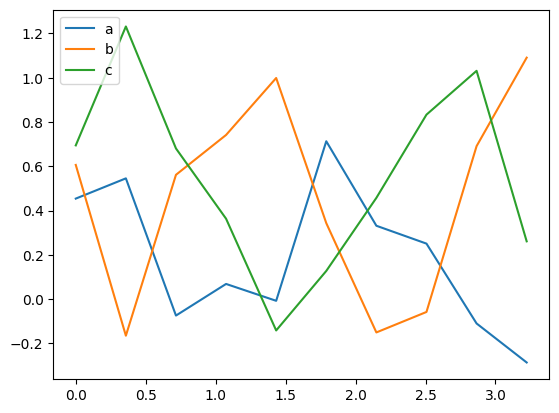

In [3]:
list_entite = ['a','b','c']
max_level = dict()
max_level['a'] = 1
max_level['b'] = 1
max_level['c'] = 1

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

sca = 0.2
scmax = 1
sab = 0.3
samax = 1
sbc = 0.9
sbmax = 1

vac0a0=1
vac0a1=1.9
vac1a0=1.3
vac1a1=0.4
vba0b0=3.8
vba0b1=2.5
vba1b0=2.7
vba1b1=3.3
vcb0c0=1.5
vcb0c1=0.8
vcb1c0=1.9
vcb1c1=1.5

num = 20
initial_state  = (0.5,0.7,0.8)
nb = 10

noise1 = 0.2
noise2 = 0.2
noise3 = 0.2

cac0a0=vac0a0/(sab - 0)
cac0a1=vac0a1/(samax - sab)
cac1a0=vac1a0/(sab - 0)
cac1a1=vac1a1/(samax - sab)
cba0b0=vba0b0/(sbc - 0)
cba0b1=vba0b1/(sbmax - sbc)
cba1b0=vba1b0/(sbc - 0)
cba1b1=vba1b1/(sbmax - sbc)
ccb0c0=vcb0c0/(sca - 0)
ccb0c1=vcb0c1/(scmax -sca)
ccb1c0=vcb1c0/(sca - 0)
ccb1c1=vcb1c1/(scmax -sca)

df1 = pd.DataFrame([[0,0,0,cac0a0,cba0b0,ccb0c0]],columns=list_colums)
df2 = pd.DataFrame([[0,0,1,-cac1a0,cba0b0,ccb0c1]],columns=list_colums)
df3 = pd.DataFrame([[0,1,0,cac0a0,cba0b1,-ccb1c0]],columns=list_colums)
df4 = pd.DataFrame([[0,1,1,-cac1a0,cba0b1,-ccb1c1]],columns=list_colums)
df5 = pd.DataFrame([[1,0,0,cac0a1,-cba1b0,ccb0c0]],columns=list_colums)
df6 = pd.DataFrame([[1,0,1,-cac1a1,-cba1b0,ccb0c1]],columns=list_colums)
df7 = pd.DataFrame([[1,1,0,cac0a1,-cba1b1,-ccb1c0]],columns=list_colums)
df8 = pd.DataFrame([[1,1,1,-cac1a1,-cba1b1,-ccb1c1]],columns=list_colums)

celerities=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8])
celerities['signature'] = celerities.apply(get_signature,axis=1)

ini_discrete = ''
ini_fractional = []
if initial_state[0]>=sab:
    ini_discrete = ini_discrete+'1'
    ini_fractional = ini_fractional + [(initial_state[0]-sab)/(samax - sab)]
elif initial_state[0]<sab:
    ini_discrete = ini_discrete+'0'
    ini_fractional = ini_fractional + [initial_state[0]/sab]
    
if initial_state[1]>=sbc:
    ini_discrete = ini_discrete+'1'
    ini_fractional = ini_fractional + [(initial_state[1]-sbc)/(sbmax - sbc)]
elif initial_state[1]<sbc:
    ini_discrete = ini_discrete+'0'
    ini_fractional = ini_fractional + [initial_state[1]/sbc]
    
if initial_state[2]>=sca:
    ini_discrete = ini_discrete+'1'
    ini_fractional = ini_fractional + [(initial_state[2]-sca)/(scmax - sca)]
elif initial_state[2]<sca:
    ini_discrete = ini_discrete+'0'
    ini_fractional = ini_fractional + [initial_state[2]/sca]
    
data,t = simulation(ini_discrete,ini_fractional,num)
real_data = dc(data)
for i in range(data.shape[0]):
    if data[i][0] < 1:
        real_data[i][0] = data[i][0]*sab
    elif data[i][0] >= 1:
        real_data[i][0] = (data[i][0] - 1)*(samax - sab) + sab
    if data[i][1] < 1:
        real_data[i][1] = data[i][1]*sbc
    elif data[i][1] >= 1:
        real_data[i][1] = (data[i][1] - 1)*(sbmax - sbc) + sbc
    if data[i][2] < 1:
        real_data[i][2] = data[i][2]*sca
    elif data[i][2] >= 1:
        real_data[i][2] = (data[i][2] - 1)*(scmax - sca) + sca
noise_data = np.zeros((nb+1,3))
delta_t = t[-1][0]/nb
new_t = np.zeros((nb+1,1))
for i in range(nb+1):
    new_t[i][0] = i*delta_t
    for j in range(t.shape[0]-1):
        if t[j][0] <= new_t[i][0] and t[j+1][0] >= new_t[i][0]:
            noise_data[i][0] = random.gauss(0,noise1) + real_data[j][0] + (real_data[j+1][0] - real_data[j][0])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
            noise_data[i][1] = random.gauss(0,noise2) + real_data[j][1] + (real_data[j+1][1] - real_data[j][1])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
            noise_data[i][2] = random.gauss(0,noise3) + real_data[j][2] + (real_data[j+1][2] - real_data[j][2])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
            break
plt.plot(new_t[0:nb],noise_data[0:nb,0],label='a')
plt.plot(new_t[0:nb],noise_data[0:nb,1],label='b')
plt.plot(new_t[0:nb],noise_data[0:nb,2],label='c')
plt.legend()
plt.savefig('simu1',dpi=1200)

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, SimpleRNN, concatenate, LSTM, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

In [21]:
n_sim = 1000
num = 20
nb = 100
dataset = md.create_dataset_sc(n_sim, num, nb, noise=0.0)
dataset_score = dataset[0]
y = dataset[1]

In [22]:
dataset_ab = np.zeros((n_sim, 99, 2, 2))

for k1 in range(n_sim):
    for k2 in range(nb-1):
        dataset_ab[k1, k2, 0, 0] = dataset_score[k1, k2, 0]
        dataset_ab[k1, k2, 1, 0] = dataset_score[k1, k2+1, 0]
        dataset_ab[k1, k2, 0, 1] = dataset_score[k1, k2, 1]
        dataset_ab[k1, k2, 1, 1] = dataset_score[k1, k2+1, 1]

In [23]:
step = 0.1
score_3d = []
for k in range(n_sim):
    print(k)
    X = dataset_score[k, :]
    score_3d += [md.seuil_grid_search3d(X, step, min=0, max=1, nb_points=3)[0]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
liste_dataset_ab_maps = [0]*n_sim
for s in range(n_sim):
    liste_dataset_ab_maps[s] = [score_3d[s]]
    liste_dataset_ab_maps[s] += [dataset_ab[s, :, :, :]]
       
X_train_ab_3d, X_test_ab_3d, y_train_ab_3d, y_test_ab_3d = train_test_split(liste_dataset_ab_maps, y[:, 1], train_size = 0.7, shuffle = False)  

X_train_ab_3d_2 = [0]*nb
X_train_ab_3d_2[0] = np.zeros((len(X_train_ab_3d), int(1/step)+1, int(1/step)+1, int(1/step)+1))
for s in range(len(X_train_ab_3d)):
    X_train_ab_3d_2[0][s] = X_train_ab_3d[s][0]
    
for k in range(1, nb):
    X_train_ab_3d_2[k] = np.zeros((len(X_train_ab_3d), 2, 2))
    for s in range(len(X_train_ab_3d)):
        X_train_ab_3d_2[k][s] = X_train_ab_3d[s][1][k-1]

X_test_ab_3d_2 = [0]*nb
X_test_ab_3d_2[0] = np.zeros((len(X_test_ab_3d), int(1/step)+1, int(1/step)+1, int(1/step)+1))
for s in range(len(X_test_ab_3d)):
    X_test_ab_3d_2[0][s] = X_test_ab_3d[s][0]
    
for k in range(1, nb):
    X_test_ab_3d_2[k] = np.zeros((len(X_test_ab_3d), 2, 2))
    for s in range(len(X_test_ab_3d)):
        X_test_ab_3d_2[k][s] = X_test_ab_3d[s][1][k-1]

In [25]:
list_input = []
list_output = []


input_map = Input(shape = (int(1/step)+1, int(1/step)+1, int(1/step)+1,)) # map 3d
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_map)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)
x = Model(inputs=input_map, outputs=x)

list_output += [x.output]
list_input += [x.input]

for k in range (nb-1):
    input_k = Input(shape = (2, 2,))
    x = Dense(32)(input_k)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Model(inputs=input_k, outputs=x)
    list_output += [x.output]
    list_input += [x.input]

output_N1 = concatenate(list_output)

z = Dense(4, activation="relu")(output_N1)
z = Dense(2, activation="relu")(z)
z = Dense(1, activation="linear")(z)

model_ab = Model(inputs=list_input, outputs=z)

model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

In [26]:
tf.config.experimental_run_functions_eagerly(True)

In [27]:
tf.config.run_functions_eagerly(True)

In [28]:
history_ab = model_ab.fit(x=X_train_ab_3d_2, y=y_train_ab_3d, epochs=100, batch_size = 16, validation_split=0.3)

y_pred_ab = model_ab.predict(X_test_ab_3d_2)

d:\programmes\Pyzo\Python\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
31/31 [==============================] - 35s 1s/step - loss: 0.5027 - mean_absolute_error: 0.5004 - val_loss: 0.4852 - val_mean_absolute_error: 0.4795
Epoch 2/100
31/31 [==============================] - 32s 1s/step - loss: 0.4489 - mean_absolute_error: 0.4478 - val_loss: 0.4510 - val_mean_absolute_error: 0.4451
Epoch 3/100
31/31 [==============================] - 32s 1s/step - loss: 0.4171 - mean_absolute_error: 0.4144 - val_loss: 0.4178 - val_mean_absolute_error: 0.4122
Epoch 4/100
31/31 [==============================] - 33s 1s/step - loss: 0.3875 - mean_absolute_error: 0.3879 - val_loss: 0.3863 - val_mean_absolute_error: 0.3817
Epoch 5/100
31/31 [==============================] - 31s 995ms/step - loss: 0.3597 - mean_absolute_error: 0.3588 - val_loss: 0.3556 - val_mean_absolute_error: 0.3520
Epoch 6/100
31/31 [==============================] - 32s 1s/step - loss: 0.3353 - mean_absolute_error: 0.3354 - val_loss: 0.3289 - val_mean_absolute_error: 0.3260
Epoch 7/100
31/31 [

In [39]:
def plot_history(history, key):
    plt.figure(figsize=(10,7))
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()

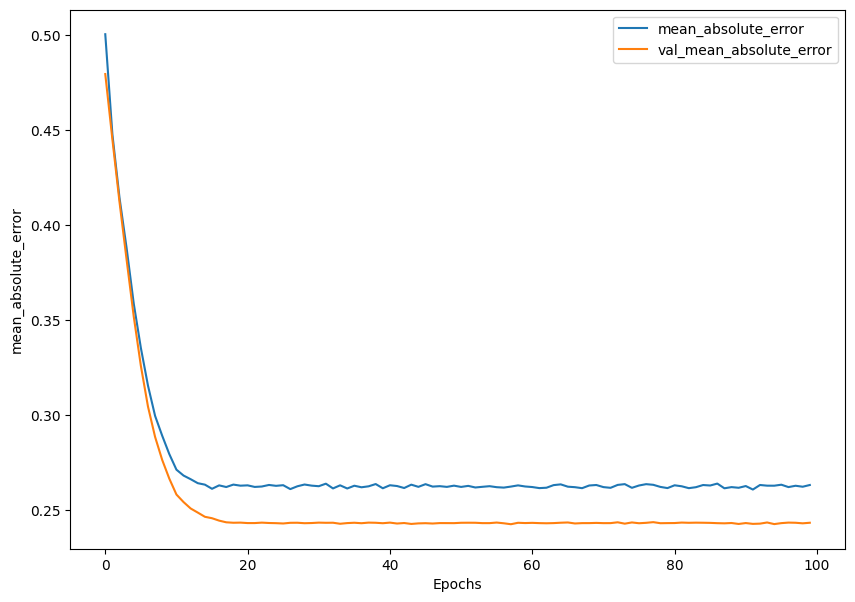

0.24737771494977978


In [40]:
plot_history(history_ab, 'mean_absolute_error')
print(mean_absolute_error(y_pred_ab, y_test_ab_3d))

In [17]:
num_fold = 5

kfold = KFold(n_splits=num_fold, shuffle=True)

loss_per_fold = []

fold_no = 1
for train, test in kfold.split(liste_dataset_ab_maps, y[:, 1]):
    print(fold_no)
    list_input = []
    list_output = []

    input_map = Input(shape = (int(1/step)+1, int(1/step)+1, int(1/step)+1,))
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_map)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(8, activation='relu')(x)
    x = Model(inputs=input_map, outputs=x)

    list_output += [x.output]
    list_input += [x.input]

    for k in range (nb-1):
        input_k = Input(shape = (2, 2,))
        x = Dense(32)(input_k)
        x = Dropout(0.3)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)
    
    model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    X_train = [0]*nb
    X_train[0] = np.zeros((len(train), int(1/step)+1, int(1/step)+1, int(1/step)+1))
    for i in range (len(train)):
        X_train[0][i] = liste_dataset_ab_maps[train[i]][0]
    
    for k in range(1, nb):
        X_train[k] = np.zeros((len(train), 2, 2))
        for i in range(len(train)):
            X_train[k][i] = liste_dataset_ab_maps[train[i]][1][k-1]

    X_test = [0]*nb
    X_test[0] = np.zeros((len(test), int(1/step)+1, int(1/step)+1, int(1/step)+1))
    for i in range(len(test)):
        X_test[0][i] = liste_dataset_ab_maps[test[i]][0]
    
    for k in range(1, nb):
        X_test[k] = np.zeros((len(test), 2, 2))
        for i in range(len(test)):
            X_test[k][i] = liste_dataset_ab_maps[test[i]][1][k-1]
            
    y_train = y[train, 1]
    y_test = y[test, 1]
    
    history = model_ab.fit(X_train, y_train,
              batch_size=16,
              epochs=1000,
              validation_split=0.3)

    scores = model_ab.evaluate(X_test, y_test)
    print(f'Score for fold {fold_no}: {model_ab.metrics_names[0]} of {scores[0]}%')
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

1
------------------------------------------------------------------------
Training for fold 1 ...


d:\programmes\Pyzo\Python\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/1000
10/35 [=======>......................] - ETA: 19s - loss: 0.3424 - mean_absolute_error: 0.3424

KeyboardInterrupt: 

In [ ]:
#Score 1d
step = 0.1
score_1d = []
for k in range(n_sim):
    print(k)
    X = dataset_score[k, :]
    score_3d += [md.seuil_grid_search1d(X, step, min=0, max=1, nb_points=1)[0]]